# Data Analyst vs. Data Scientist: Unveiling the Salary Divide in the World of Data

## Introduction

Understanding average salaries and differences between roles is crucial for making informed decisions aligning with personal aspirations and financial goals in a data-related career (Kaur et.al, 2022). Here we delve into the realm of data careers **to compare the average income of employees (USD) in two different data-related roles ("Data Analyst" vs "Data Engineer") and  then determine if there’s a significant difference between the two groups**. This will provide valuable insights for those seeking to carve their path in the world of data.

This dataset describes 12 attributes, of which we will focus on the specific ones listed below: 

`job_title` : The role worked during the year, focusing on “Data Analyst” and “ Data Science”.

`salary_in_usd`: The salary in USD. 

For our location parameter, we have chosen the mean to help determine the central tendency of the two groups and identify roles with higher or lower average salaries. The scale parameter, standard deviation, measures income variability. Comparing the standard deviations of the two groups reveals salary variation within each role: a smaller deviation indicates more consistency, while a larger deviation indicates greater variability. 

Let $s_1$ be the mean salary for a data analyst and $s_2$ be the mean salary for a data engineer. Now, we can declare our two hypotheses:

$H_0$: $s_1$ = $s_2$. There is no difference in the mean salaries between a data analyst and data engineer.

$H_1$: $s_1 \neq s_2$. There is a difference in the mean salaries between a data analyst and data engineer.

We aim to assess whether any observed differences in the sample mean (average salaries) between the two groups are due to random chance or if they represent a real difference in the population means. 

## Preliminary Results

In [1]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# setting seed for entire project
set.seed = 4850

Download the dataset from the url and store it into a local file.

In [3]:
url = 'https://raw.githubusercontent.com/aaryan-rampal/stat-201-project/main/data/ds_salaries.csv'

download.file(url, destfile = "data/ds_salaries.csv")

Read the file into the dataframe `salary_original`. We will need to wrangle this original dataframe by selecting our columns of interest and filtering `NA` values. 

In [4]:
salary_original <- read_csv("data//ds_salaries.csv")

# clean up columns 
salary <- salary_original |>
    mutate(id = ...1) |>
    select(-...1) |>
    select(job_title, salary_in_usd) |>
    filter(!is.na(salary_in_usd), 
           (job_title == "Data Analyst" | job_title == "Data Scientist")) |>
    mutate(job_title = as_factor(job_title)) 
    

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
head(salary, 6)
table(select(salary, job_title))

job_title,salary_in_usd
<fct>,<dbl>
Data Scientist,79833
Data Analyst,72000
Data Scientist,35735
Data Scientist,51321
Data Scientist,40481
Data Scientist,39916



Data Scientist   Data Analyst 
           143             97 

It looks like `salary` has been wrangled properly and contains a fair amount of datapoints for both job titles. 

Let's visualize the sampling distribution of salaries for both jobs. 

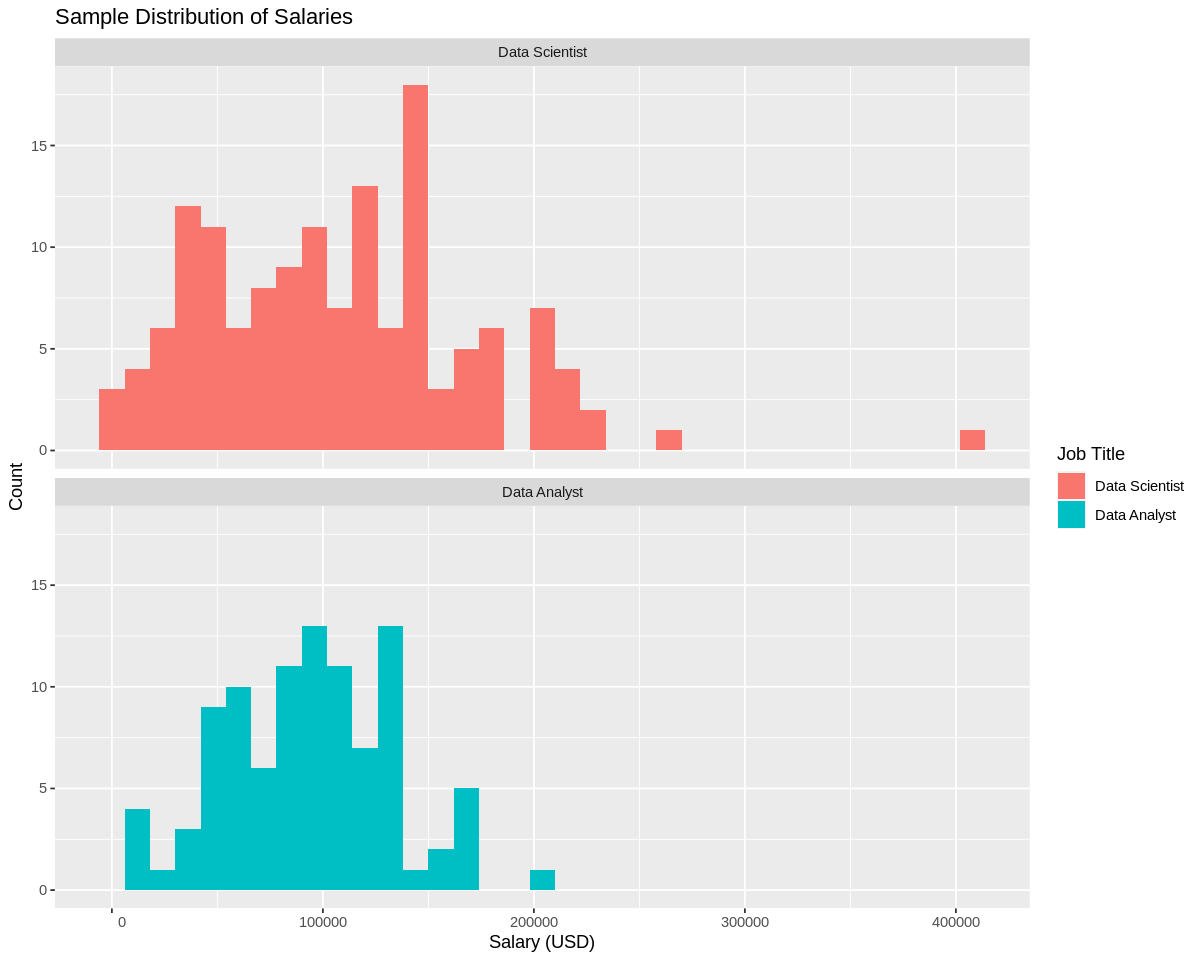

In [6]:
options(repr.plot.height = 8, repr.plot.width = 10)

# visualization of original data sample
salary_sample_dist <- salary |>
    ggplot(aes(x = salary_in_usd, fill = job_title)) +
    geom_histogram(binwidth = 12000) +
    facet_wrap(~ job_title, ncol = 1) +
    ggtitle("Sample Distribution of Salaries") +
    xlab("Salary (USD)") +
    ylab("Count") +
    labs(fill = "Job Title") + 
    scale_x_continuous(labels = function(x) format(x, scientific = FALSE))

salary_sample_dist

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


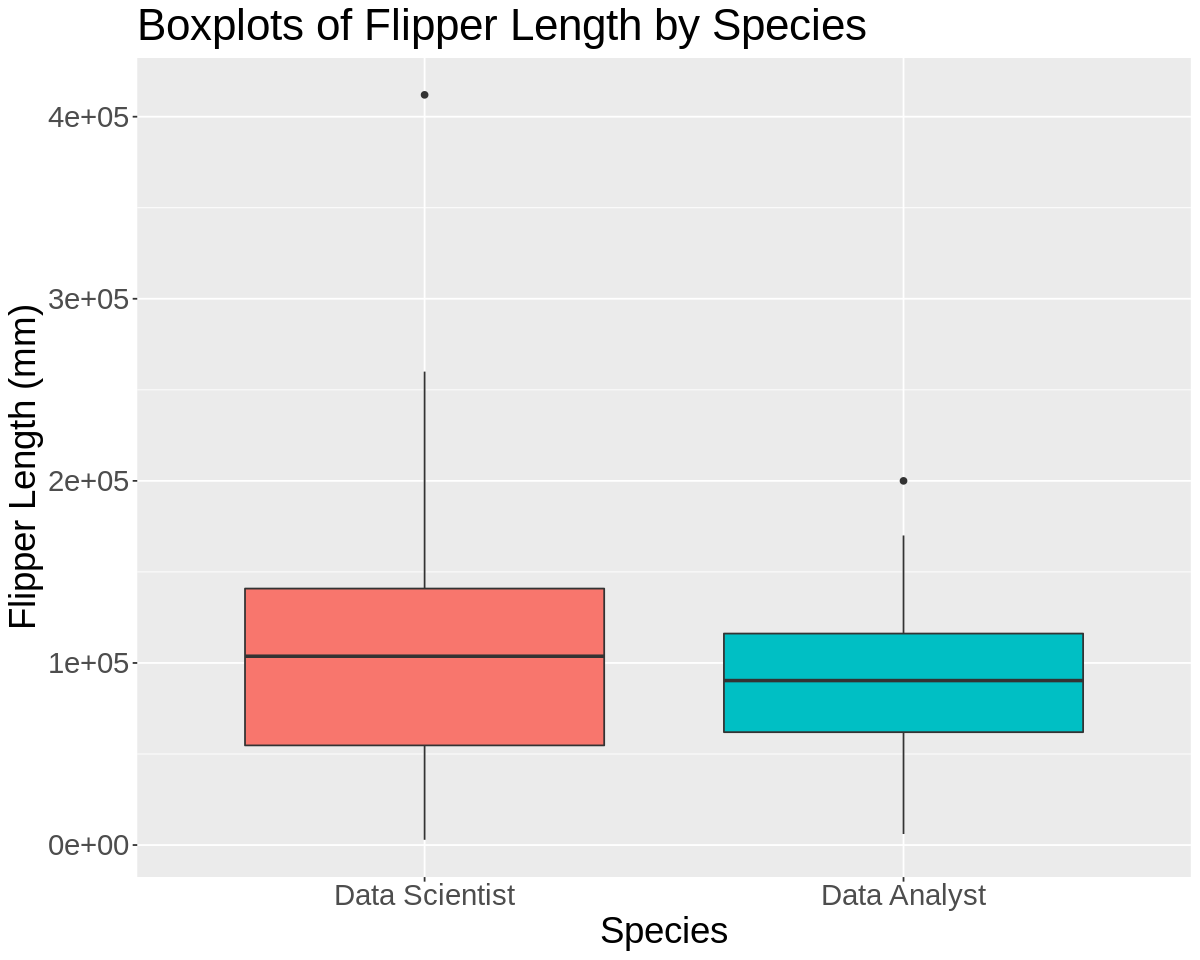

In [7]:
salary_boxplot <-
    salary %>% 
    ggplot() +
    geom_boxplot(aes(job_title, salary_in_usd, fill=job_title)) +
    theme(text = element_text(size = 22)) +
    ggtitle("Boxplots of Flipper Length by Species") + 
    xlab("Species") + 
    ylab("Flipper Length (mm)") + 
    guides(fill = FALSE)
### END SOLUTION

salary_boxplot

In [8]:
salary_summarized <- salary |>
    group_by(job_title) |>
    summarize(n = n(),
              sample_mean = mean(salary_in_usd),
              sample_var = sd(salary_in_usd)^2)

salary_summarized

job_title,n,sample_mean,sample_var
<fct>,<int>,<dbl>,<dbl>
Data Scientist,143,108187.83,4110456319
Data Analyst,97,92893.06,1596887583


At a preliminary glance, it looks like data analysts are paid less on average when compared to data scientists. But is this difference significant? This is what we shall attempt to find out.

## Methods: Plan

Given our approach using hypothesis testing to compare the average income of jobs titled “Data Analyst” and “Data Engineer”, we are testing our assumptions prior to actuating them. This results in a trustworthy report as the premises carried over from the hypothesis test will be verified for future implementation to the broader population. 

Although current visualizations and estimates provide a brief understanding of the dataset, they cannot be generalized or alluded to the entire field of data-related careers. As we plan to carry out a hypothesis test upon the average income for both job titles, a confidence interval will also be constructed for sampling distributions of the average income for both job titles. 

We expect to estimate the true population parameter of mean income for two job titles as well as test our hypothesis that the average income for the two job titles are significantly different. This report is intended to provide support for those making choices about the pursuit of one’s profession and may evidently lead to questions regarding the difference in difficulty or commitment of data-related careers based on the income.


In [16]:
# two sample t-test
t_test_results <- tidy(
                   t.test(x = salary %>% filter(job_title == "Data Scientist") %>% pull(salary_in_usd), 
                          y = salary %>% filter(job_title == "Data Analyst") %>% pull(salary_in_usd),
                          alternative = "two.sided"))

t_test_results

test_stat <- t_test_results |>
    select(statistic) |>
    pull()

p_value <- t_test_results |>
    select(p.value) |>
    pull()

p_value

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
15294.77,108187.8,92893.06,2.274778,0.02381541,236.4901,2048.91,28540.63,Welch Two Sample t-test,two.sided


[1] 0.02381541

Since the p-value < 0.05, we already know that the difference between the two means are statistically signifincant.  

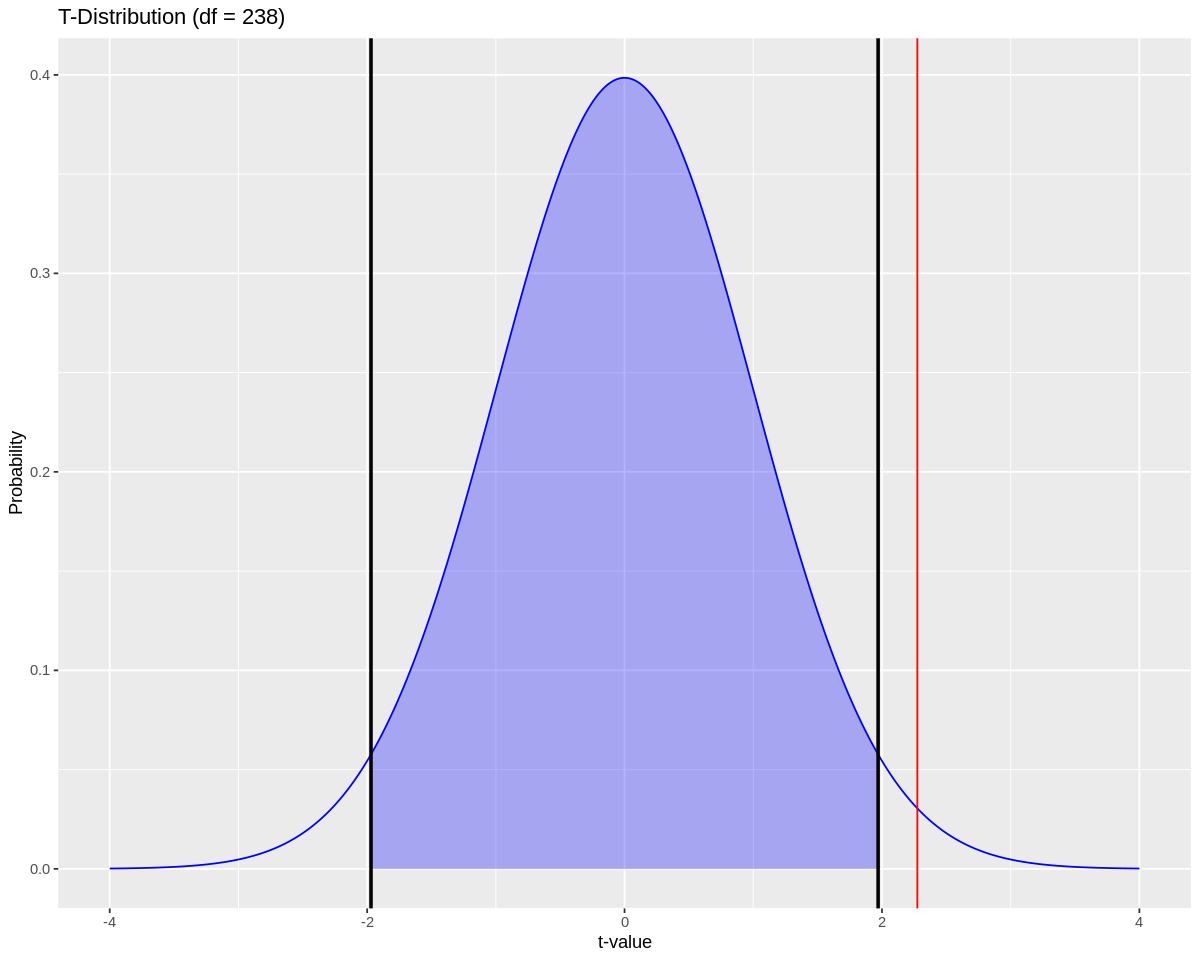

In [98]:
t_values <- seq(-4, 4, by = 0.01)  # Adjust the range and increment as needed
df <- 238
probabilities <- dt(t_values, df = df)

data <- data.frame(t = t_values, p = probabilities)
ci <- tibble(
    lower = qt(0.025, df),
    upper = qt(0.975, df))

# Create the ggplot plot
t_dist <- ggplot(data, aes(x = t, y = p)) +
    geom_line(color = "blue") +
    labs(title = "T-Distribution (df = 238)", x = "t-value", y = "Probability") +
    geom_ribbon(data = data %>% filter(t >= ci$lower & t <= ci$upper),
                aes(ymin = 0, ymax = p), 
                fill = "blue", alpha = 0.3) +
    geom_vline(xintercept = test_stat, color = 'red') +
    geom_vline(xintercept = ci$lower, size = 1) +
    geom_vline(xintercept = ci$upper, size = 1)

# Display the plot
t_dist

We can visually see that our test-statistic falls outside the 95% confidence interval.  

## References

T. Z. Quan and M. Raheem, "Salary Prediction in Data Science Field Using Specialized Skills and Job Benefits–A Literature", Journal of Applied Technology and Innovation, vol. 6, no. 3, pp. 70-74, 2022, ISSN 2600-7304.

A. Kaur, D. Verma and N. Kaur, "Utilizing Quantitative Data Science Salary Analysis to Predict Job Salaries," 2022 2nd International Conference on Innovative Sustainable Computational Technologies (CISCT), Dehradun, India, 2022, pp. 1-4, doi: 10.1109/CISCT55310.2022.10046491.